### LOAD NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### DATA UTILITIES

In [2]:
BASE_URL = '../input/chest-xray-pneumonia/chest_xray'
FOLDERS = ['test', 'val', 'train']
CATEGORIES = ['NORMAL', 'PNEUMONIA']

In [3]:
#get all the image filenames on normal class and create a dataframe
class_normal = []

for f in FOLDERS:
    folder = os.path.join(BASE_URL, f)

    for path in os.listdir(os.path.join(folder, 'NORMAL')):
        class_normal.append([os.path.join(folder, 'NORMAL/'+path), 0])
normal_df = pd.DataFrame(class_normal, columns=['filepaths', 'labels'])

In [4]:
#get all the image filenames on pneumonia class and create a dataframe

class_pneumonia = []

for f in FOLDERS:
    folder = os.path.join(BASE_URL, f)

    for path in os.listdir(os.path.join(folder, 'PNEUMONIA')):
        class_pneumonia.append([os.path.join(folder, 'PNEUMONIA/'+path), 1])
pneumonia_df = pd.DataFrame(class_pneumonia, columns=['filepaths', 'labels'])

In [5]:
#concatenate the two dataframes we created above
df = pd.concat([normal_df, pneumonia_df], axis=0).reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,filepaths,labels
0,../input/chest-xray-pneumonia/chest_xray/test/...,0
1,../input/chest-xray-pneumonia/chest_xray/test/...,0
2,../input/chest-xray-pneumonia/chest_xray/test/...,0
3,../input/chest-xray-pneumonia/chest_xray/test/...,0
4,../input/chest-xray-pneumonia/chest_xray/test/...,0


In [6]:
#show dataframe shape
print('DATAFRAME SHAPE: ',df.shape)
print(df.labels.value_counts())

DATAFRAME SHAPE:  (5856, 2)
1    4273
0    1583
Name: labels, dtype: int64


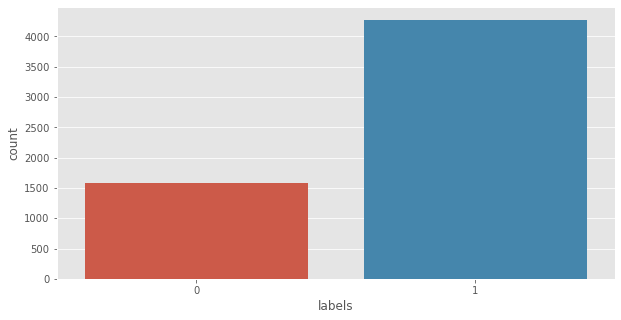

In [7]:
#show countplot
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
sns.countplot(df.labels);

* As you can see from the plot above, the data is imbalanced,
* We can balance the data by augmenting the images from normal class.

In [8]:
#function to load images and convert them to array
def read_img(path, target_size):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img) /255.
    return img

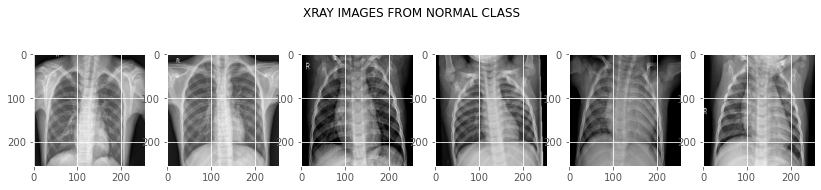

In [9]:
#show sample image from normal_class

fig, ax = plt.subplots(1,6,figsize=(14,3));
plt.suptitle('XRAY IMAGES FROM NORMAL CLASS')

for i,path in enumerate(normal_df.filepaths[:6].values):
    ax[i].imshow(read_img(path, (255,255)))


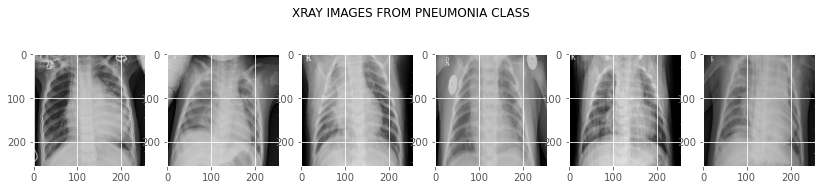

In [10]:
#show sample image from pneumonia_class

fig, ax = plt.subplots(1,6,figsize=(14,3));
plt.suptitle('XRAY IMAGES FROM PNEUMONIA CLASS')

for i,path in enumerate(pneumonia_df.filepaths[:6].values):
    ax[i].imshow(read_img(path, (255,255)))


### IMAGE AUGMENTATION

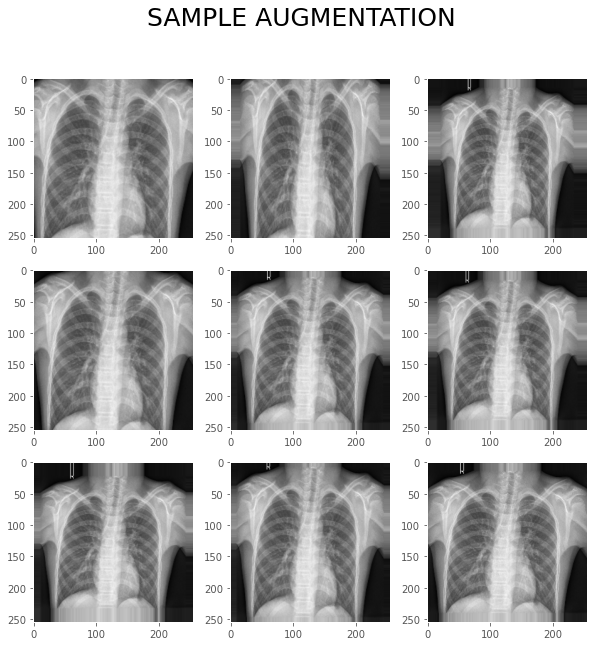

In [11]:
#create a imagegenerator
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2
)

#load a sample image
sample_image = (read_img(normal_df.filepaths[0], (255,255)))

plt.figure(figsize=(10,10))
plt.suptitle('SAMPLE AUGMENTATION', fontsize=25)

i = 0

#generate and show
for batch in datagen.flow(tf.expand_dims(sample_image,0), batch_size=32):
    plt.subplot(3,3, i+1)
    plt.grid(False)
    plt.imshow(tf.squeeze(batch, 0));
    
    if i == 8:
        break
    i = i+1
plt.show();

#### NOW AUGMENT ALL THE IMAGES IN THE NORMAL CLASS

In [12]:
augmented_img = []

#function for augmentation
def augment(path):
    #load images then transform
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (150,150))
    i=0
    for batch in datagen.flow(tf.expand_dims(img, 0), batch_size=32):
        augmented_img.append(tf.squeeze(batch, 0))
        
        if i == 2:
            break
        i = i+1

#apply the augmentation function
normal_df['filepaths'].apply(augment)

0       None
1       None
2       None
3       None
4       None
        ... 
1578    None
1579    None
1580    None
1581    None
1582    None
Name: filepaths, Length: 1583, dtype: object

In [13]:
#convert the generated images as tensors
normal_tensor =  tf.convert_to_tensor(augmented_img)
normal_tensor.shape

TensorShape([4749, 150, 150, 3])

#### LOAD THE XRAY IMAGES WITH PNEUMONIA

In [14]:
#same function but without augmentation
pneumonia_tensor = []
IMAGE_SIZE = 150
def map_fn(path):
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    pneumonia_tensor.append(img)
pneumonia_df.filepaths.apply(map_fn)

0       None
1       None
2       None
3       None
4       None
        ... 
4268    None
4269    None
4270    None
4271    None
4272    None
Name: filepaths, Length: 4273, dtype: object

In [16]:
#convert to tensor
pneumonia_tensor = tf.convert_to_tensor(pneumonia_tensor)
pneumonia_tensor.shape

TensorShape([4273, 150, 150, 3])

In [17]:
#generate labels
normal_labels = tf.zeros(len(normal_tensor), dtype = np.int64)
pneumonia_labels = tf.ones(len(pneumonia_tensor), dtype=np.int64)

### CREATE A TENSOR DATASET

In [19]:
tensor_dataset = tf.data.Dataset.from_tensor_slices( (tf.concat([normal_tensor, pneumonia_tensor], axis=0),
                                                      tf.concat([normal_labels, pneumonia_labels], axis=0)))

### SPLIT THE DATA

In [20]:
# TRAIN_SIZE = int(len(tensor_dataset) *0.7)
#BUFFER_SIZE = 101
#tensor_dataset = tensor_dataset.shuffle(BUFFER_SIZE)
# train_data = tensor_dataset.take(TRAIN_SIZE)
# test_data = tensor_dataset.skip(TRAIN_SIZE)

def is_test(x, y):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x,y: y

test_dataset = tensor_dataset.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = tensor_dataset.enumerate() \
                    .filter(is_train) \
                    .map(recover)

In [21]:
#just storing the labels for future use
train_labels = []
for i,l in train_dataset.take(-1):
    train_labels.append(l)
    
test_labels = []
for i,l in test_dataset.take(-1):
    test_labels.append(l)

In [22]:
#value counts on datasets
print('TRAIN DATA VALUE COUNTS: ',np.bincount(np.array(test_labels)))
print('TRAIN DATA VALUE COUNTS: ',np.bincount(np.array(train_labels)))

TRAIN DATA VALUE COUNTS:  [1188 1068]
TRAIN DATA VALUE COUNTS:  [3561 3205]


In [75]:
#Looks good! the data is balanced now

### BATCH THE IMAGES

In [23]:
#you can try 16, but it will slow down the training
BATCH_SIZE = 32

#shuffle the train data
train_data = train_dataset.shuffle(10000).batch(BATCH_SIZE)
test_data = test_dataset.batch(BATCH_SIZE)

In [24]:
#check the labels per batch if they are truly shuffled, haha i have trust issues though
for i,l in train_data.take(20):
    print(l)

tf.Tensor([1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0], shape=(32,), dtype=int64)
tf.Tensor([1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1], shape=(32,), dtype=int64)
tf.Tensor([1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 

In [25]:
#check the shape per batch
for i,l in train_data.take(1):
    print(i.shape)

(32, 150, 150, 3)


### TRANSFER LEARNING

In [26]:
#define the input shape
INPUT_SHAPE = (150,150,3)

#i'll use mobilenetv2 and you try anything you want.
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

#freeze the weights of convolutional layer
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [27]:
#check the output shape of convolutional layer
for i, l in train_data.take(1):
    print(base_model(i).shape)

(32, 5, 5, 1280)


### ADD A DENSE LAYER FOR IMAGE CLASSIFICATION

In [28]:
model = Sequential()
model.add(base_model)
#you can try Flatten instead of GlobalAveragePooling
model.add(Layers.GlobalAveragePooling2D())
model.add(Layers.Dense(128, activation='relu'))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
#set a callback
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
#Throw the data
history = model.fit(train_data, epochs=4, validation_data= test_data, callbacks=[callbacks])

Epoch 1/4
212/212 [==============================] - 12s 58ms/step - loss: 0.0956 - accuracy: 0.9622 - val_loss: 0.0314 - val_accuracy: 0.9902
Epoch 2/4
212/212 [==============================] - 12s 56ms/step - loss: 0.0354 - accuracy: 0.9858 - val_loss: 0.0199 - val_accuracy: 0.9947
Epoch 3/4
212/212 [==============================] - 11s 51ms/step - loss: 0.0232 - accuracy: 0.9917 - val_loss: 0.0208 - val_accuracy: 0.9925
Epoch 4/4
212/212 [==============================] - 11s 52ms/step - loss: 0.0261 - accuracy: 0.9898 - val_loss: 0.0141 - val_accuracy: 0.9942


In [ ]:
#Owww Bingo!

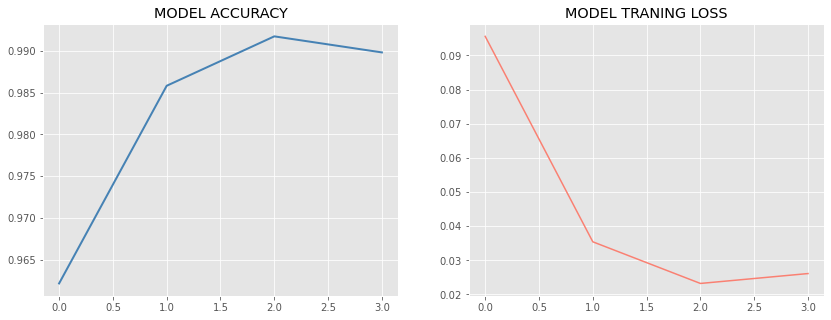

In [45]:
#show model training accuracy and loss
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].set_title('MODEL ACCURACY')
ax[1].set_title('MODEL TRANING LOSS')
ax[0].plot(history.history['accuracy'], color= 'steelblue', lw=2);
ax[1].plot(history.history['loss'], color='salmon');

In [31]:
#get the predictions
predictions = model.predict_classes(test_data)

In [65]:
#print a classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1188
           1       1.00      0.99      0.99      1068

    accuracy                           0.99      2256
   macro avg       0.99      0.99      0.99      2256
weighted avg       0.99      0.99      0.99      2256



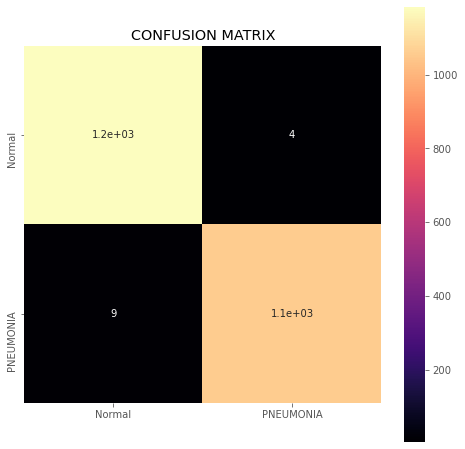

In [74]:
#here is our favorite, the confusion matrix!
conf_mat = confusion_matrix(np.array(test_labels), predictions)
plt.figure(figsize=(8,8))
plt.title('CONFUSION MATRIX')
sns.heatmap(conf_mat, annot=True, 
            yticklabels=['Normal', 'PNEUMONIA'],
            xticklabels=['Normal', 'PNEUMONIA'],
            square=True, cmap='magma');

### MODEL TESTING

In [62]:
for img, label in test_data.take(1):
    sample_img = img[1]
    img_true_label = label[1]

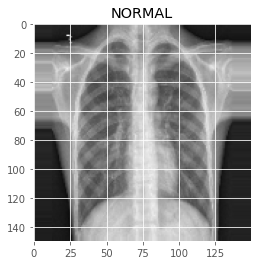

In [63]:
pred = np.array(model.predict_classes(tf.expand_dims(sample_img, 0))).flatten()[0]
plt.title(CATEGORIES[pred])
plt.imshow(sample_img);

In [64]:
#show image true label
print('IMAGE TRUE LABEL: ', CATEGORIES[img_true_label])

IMAGE TRUE LABEL:  NORMAL
